<a href="https://colab.research.google.com/github/Pratch-yani/Face_Shape_Classification/blob/main/4_IMAGE_AUGMENTATION_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project:  Face Shape Classification - Part 4

This notebook explores image augmentation, including:
- Exploratory Data Analysis to identify the right variables (flip, degrees of rotation)
- Preprocessing & Modelling




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libaries & Define initial functions

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2 as cv2
from scipy import ndimage
import random
import pickle
import seaborn as sns
import itertools
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [ ]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

     |████████████████████████████████| 2.3MB 8.1MB/s 


In [ ]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images from an image array'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [ ]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [ ]:
detector = MTCNN()  # creates detector  

def extract_face(img, target_size=(224,224)):
    '''this functions extract the face from different images by 
    1) finds the facial bounding box
    2) slightly expands top & bottom boundaries to include the whole face
    3) crop into a square shape
    4) resize to target image size for modelling
    5) if the facial bounding box in step 1 is not found, image will be cropped & resized to 224x224 square'''
           
    # 1. detect faces in an image
      
    results = detector.detect_faces(img)
    if results == []:    # if face is not detected, call function to crop & resize by keeping aspect ratio
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img

    
  

In [ ]:
def plot_results(mod_history, metric, epochs):
      
      # Check out our train loss and test loss over epochs.
      train_metric = mod_history.history[metric]
      val = 'val_' + metric
      test_metric = mod_history.history[val]

      # Set figure size.
      plt.figure(figsize=(12, 8))

      # Generate line plot of training, testing loss over epochs.
      plt.plot(train_metric, label=f'Training {metric}', color='#185fad')
      plt.plot(test_metric, label=f'Testing {metric}', color='orange')

      # Set title
      plt.title(f'Training and Testing {metric} by Epoch', fontsize = 25)
      plt.xlabel('Epoch', fontsize = 18)
      plt.ylabel('Categorical Crossentropy', fontsize = 18)
      plt.xticks(range(0,epochs,5), range(0,epochs,5))
      plt.legend(fontsize = 18);

In [ ]:
def make_predictions(mod_name, steps=20):
    preds = mod_name.predict(X_test,steps=steps)
    preds = preds.argmax(axis=-1)

    y_test_labels = np.argmax(y_test, axis=-1)

    cm = confusion_matrix(y_test_labels,preds)

    plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                          title='Face Shape Normalized')

    plt.show()



In [ ]:
cm_plot_labels = ['Heart','Oblong','Oval','Round', 'Square']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(16,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_summary_results(mod_name, mod_history, epochs):
    plot_results(mod_history, 'loss',epochs)
    plot_results(mod_history, 'accuracy', epochs)
    make_predictions(mod_name)

## Image Augmentation - based on RGB

In [ ]:
# create path to images in examples

ex_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples'
ex_files = os.listdir(ex_path)

examples = []

for i in ex_files:
    img = os.path.join(ex_path,i)
    examples.append(img)
    
examples = sorted(examples)
examples

['/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/01_heart.jpg',
 '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/02_oblong.jpg',
 '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/03_oval.jpg',
 '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/04_round.jpg',
 '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/05_square.jpg',
 '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/06_portrait.jpg',
 '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data_face_shape/examples/07_landscape.jpg']

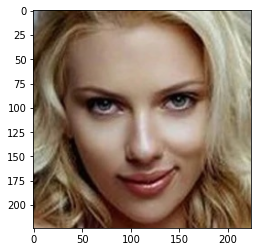

In [ ]:
# from the image that we've previously cropped with face detection bounding box
img = cv2.imread(examples[0])
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
new_face = extract_face(rgb)
plt.imshow(new_face);

To account for variations in a face image, we will augment the images as follows:
- Flip horizontally left/right (`filplr`)
- Rotate the image between -20 and 20 degrees to account for some head tilting.

Text(0.83, 0.08, '-20 degrees')

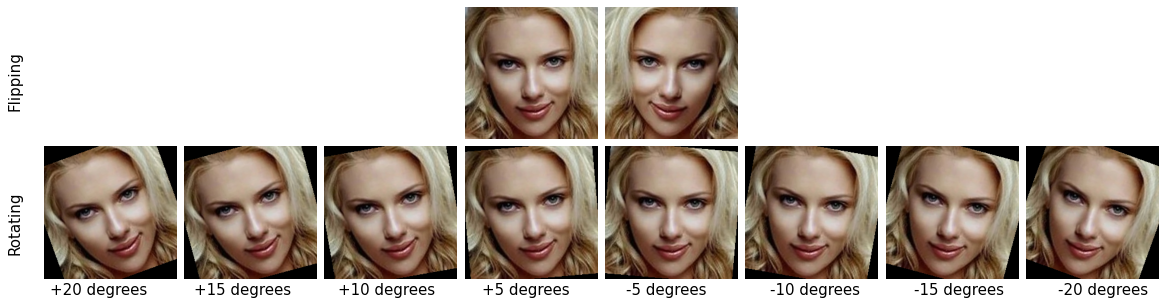

In [ ]:
# Augmenting the above image and plotting the augmented images in subplots below.

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=((8*2.5), (2*2.5)))
plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax= ax.ravel()
for i in range(16):
    ax[i].axis('off')

# Original image.
ax[3].imshow(new_face)

# Augmented image: original image flipped laterally.
img_flip = np.fliplr(new_face)
ax[4].imshow(img_flip)

# Augmented image: original image with 5deg rotation.
img_rot_pos5 = ndimage.rotate(new_face, 5, reshape=False)
ax[11].imshow(img_rot_pos5)

# Augmented image: original image with 10deg rotation.
img_rot_pos10 = ndimage.rotate(new_face, 10, reshape=False)
ax[10].imshow(img_rot_pos10)

# Augmented image: original image with 15deg rotation.
img_rot_pos15 = ndimage.rotate(new_face, 15, reshape=False)
ax[9].imshow(img_rot_pos15)

# Augmented image: original image with 20deg rotation.
img_rot_pos20 = ndimage.rotate(new_face, 20, reshape=False)
ax[8].imshow(img_rot_pos20)

# Augmented image: original image with -5deg rotation.
img_rot_neg5 = ndimage.rotate(new_face, -5, reshape=False)
ax[12].imshow(img_rot_neg5)

# Augmented image: original image with -10deg rotation.
img_rot_neg10 = ndimage.rotate(new_face, -10, reshape=False)
ax[13].imshow(img_rot_neg10)

# Augmented image: original image with -15deg rotation.
img_rot_neg15 = ndimage.rotate(new_face, -15, reshape=False)
ax[14].imshow(img_rot_neg15)

# Augmented image: original image with -20deg rotation.
img_rot_neg20 = ndimage.rotate(new_face, -20, reshape=False)
ax[15].imshow(img_rot_neg20)

plt.figtext(x=0.1, y=0.60, s="Flipping", fontsize=15, rotation=90)
plt.figtext(x=0.1, y=0.20, s="Rotating", fontsize=15, rotation=90)
plt.figtext(x=0.13, y=0.08, s="+20 degrees", fontsize=15)
plt.figtext(x=0.23, y=0.08, s="+15 degrees", fontsize=15)
plt.figtext(x=0.33, y=0.08, s="+10 degrees", fontsize=15)
plt.figtext(x=0.43, y=0.08, s="+5 degrees", fontsize=15)
plt.figtext(x=0.53, y=0.08, s="-5 degrees", fontsize=15)
plt.figtext(x=0.63, y=0.08, s="-10 degrees", fontsize=15)
plt.figtext(x=0.73, y=0.08, s="-15 degrees", fontsize=15)
plt.figtext(x=0.83, y=0.08, s="-20 degrees", fontsize=15)

For modelling stage, we will use the following:
- Horizontal flip 
- Rotation of +/- 20 degrees to account for head tilting, but beyond 20 degress would be an unlikely angle.


## Load in data files (RGB color)

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/data/"

X_train = np.asarray(pickle.load(open(path + "X_train_rgb.pickle","rb")))
y_train = np.asarray(pickle.load(open(path + "y_train_rgb.pickle","rb")))
X_test = np.asarray(pickle.load(open(path + "X_test_rgb.pickle","rb")))
y_test = np.asarray(pickle.load(open(path + "y_test_rgb.pickle","rb")))

In [ ]:
print("Data Summary")
print("--------------------")
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print("--------------------")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

Data Summary
--------------------
X_train shape (4000, 224, 224, 3)
y_train shape (4000, 5)
--------------------
X_test shape (1000, 224, 224, 3)
y_test shape (1000, 5)


## Modelling with image augmentation

In [ ]:
# use rotation of +/- 20 degrees and horizontal flip.  

datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, fill_mode='nearest')

In [ ]:
datagen.fit(X_train)

In [ ]:
model_5 = Sequential()
model_5.add(Conv2D(filters = 8,              # add this layer
                   kernel_size=3,
                   activation='relu',
                   input_shape=X_train.shape[1:]))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Conv2D(filters = 16,              # from 64
                   kernel_size=3,
                   activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Conv2D(filters = 64,             # from 128
                   kernel_size=3,
                   activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Conv2D(filters = 128,            # from 256
                   kernel_size=3,
                   activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Flatten())
model_5.add(Dense(32, activation='relu'))    # reduce from 128 to 64 to 32
model_5.add(Dropout(0.5))  ##added
model_5.add(Dense(5, activation='softmax'))

model_5.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 16)      1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        9280      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
history_5 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=400, 
                        validation_data=(X_test, y_test))

Epoch 1/400
125/125 [==============================] - 41s 330ms/step - loss: 1.6125 - accuracy: 0.1982 - val_loss: 1.6093 - val_accuracy: 0.2370
Epoch 2/400
125/125 [==============================] - 41s 325ms/step - loss: 1.6110 - accuracy: 0.2035 - val_loss: 1.6095 - val_accuracy: 0.1950
Epoch 3/400
125/125 [==============================] - 41s 324ms/step - loss: 1.6097 - accuracy: 0.1873 - val_loss: 1.6083 - val_accuracy: 0.2060
Epoch 4/400
125/125 [==============================] - 41s 325ms/step - loss: 1.6021 - accuracy: 0.2300 - val_loss: 1.5792 - val_accuracy: 0.2490
Epoch 5/400
125/125 [==============================] - 41s 324ms/step - loss: 1.5676 - accuracy: 0.2767 - val_loss: 1.5213 - val_accuracy: 0.3460
Epoch 6/400
125/125 [==============================] - 41s 325ms/step - loss: 1.5320 - accuracy: 0.3142 - val_loss: 1.4748 - val_accuracy: 0.3720
Epoch 7/400
125/125 [==============================] - 40s 323ms/step - loss: 1.4813 - accuracy: 0.3465 - val_loss: 1.3767 -

In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/extra/'
tf.keras.models.save_model(
    model_5, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/extra/assets


In [ ]:
filename = model_path + 'agmt_oct12'   # change the filename for new iterations
model_5.save(filename)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/extra/agmt_oct12/assets


Normalized confusion matrix
[[0.7   0.07  0.1   0.075 0.055]
 [0.075 0.81  0.065 0.02  0.03 ]
 [0.16  0.055 0.59  0.09  0.105]
 [0.065 0.02  0.095 0.735 0.085]
 [0.06  0.03  0.025 0.12  0.765]]


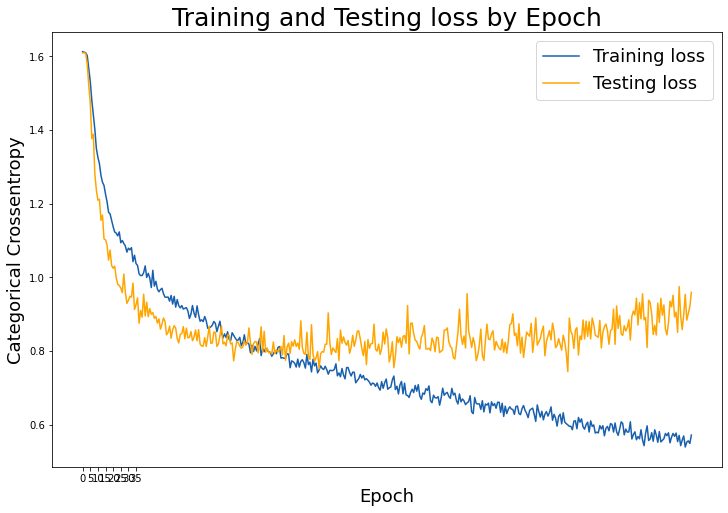

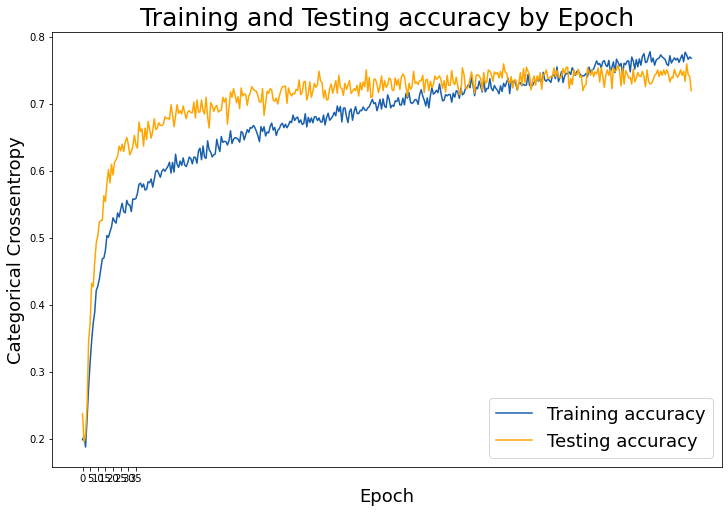

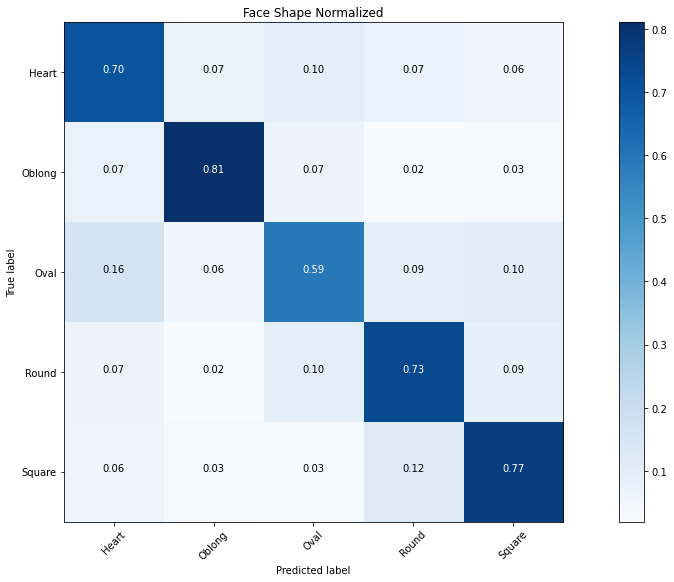

In [ ]:
plot_summary_results(model_5, history_5, 400)

- The model has not fully converged yet as the train loss and train accuracy has not stabilized.  

- The overfitting (gap between training accuracy vs. validation accuracy) is still under 0.05.

- As this model is quite slow to train, and the training accuracy is still in rising trend, let's run more epochs to see if we can increase accuracy without overfitting the model.

In [ ]:
history_5_2 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=50, 
                        validation_data=(X_test, y_test))

Epoch 1/50
125/125 [==============================] - 40s 320ms/step - loss: 0.5625 - accuracy: 0.7697 - val_loss: 0.9171 - val_accuracy: 0.7440
Epoch 2/50
125/125 [==============================] - 40s 319ms/step - loss: 0.5829 - accuracy: 0.7655 - val_loss: 0.8400 - val_accuracy: 0.7580
Epoch 3/50
125/125 [==============================] - 40s 320ms/step - loss: 0.5304 - accuracy: 0.7782 - val_loss: 0.8756 - val_accuracy: 0.7450
Epoch 4/50
125/125 [==============================] - 40s 318ms/step - loss: 0.5456 - accuracy: 0.7765 - val_loss: 0.9096 - val_accuracy: 0.7340
Epoch 5/50
125/125 [==============================] - 40s 319ms/step - loss: 0.5502 - accuracy: 0.7780 - val_loss: 0.8911 - val_accuracy: 0.7560
Epoch 6/50
125/125 [==============================] - 40s 320ms/step - loss: 0.5656 - accuracy: 0.7630 - val_loss: 0.8639 - val_accuracy: 0.7440
Epoch 7/50
125/125 [==============================] - 40s 320ms/step - loss: 0.5521 - accuracy: 0.7778 - val_loss: 0.8389 - val_ac

In [ ]:
history_5_3 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=50, 
                        validation_data=(X_test, y_test))

Epoch 1/50
125/125 [==============================] - 39s 316ms/step - loss: 0.5481 - accuracy: 0.7803 - val_loss: 0.9186 - val_accuracy: 0.7410
Epoch 2/50
125/125 [==============================] - 40s 317ms/step - loss: 0.5181 - accuracy: 0.7912 - val_loss: 0.8599 - val_accuracy: 0.7420
Epoch 3/50
125/125 [==============================] - 39s 314ms/step - loss: 0.5479 - accuracy: 0.7765 - val_loss: 0.8960 - val_accuracy: 0.7490
Epoch 4/50
125/125 [==============================] - 39s 315ms/step - loss: 0.5367 - accuracy: 0.7810 - val_loss: 0.8658 - val_accuracy: 0.7420
Epoch 5/50
125/125 [==============================] - 39s 314ms/step - loss: 0.5282 - accuracy: 0.7740 - val_loss: 0.9250 - val_accuracy: 0.7440
Epoch 6/50
125/125 [==============================] - 39s 313ms/step - loss: 0.5302 - accuracy: 0.7812 - val_loss: 0.9734 - val_accuracy: 0.7490
Epoch 7/50
125/125 [==============================] - 39s 312ms/step - loss: 0.5265 - accuracy: 0.7812 - val_loss: 0.9426 - val_ac

In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=20, 
                        validation_data=(X_test, y_test))

Epoch 1/20
125/125 [==============================] - 39s 309ms/step - loss: 0.5098 - accuracy: 0.7980 - val_loss: 1.0114 - val_accuracy: 0.7460
Epoch 2/20
125/125 [==============================] - 38s 308ms/step - loss: 0.5099 - accuracy: 0.7950 - val_loss: 1.0145 - val_accuracy: 0.7440
Epoch 3/20
125/125 [==============================] - 38s 306ms/step - loss: 0.5266 - accuracy: 0.7845 - val_loss: 0.9123 - val_accuracy: 0.7540
Epoch 4/20
125/125 [==============================] - 38s 307ms/step - loss: 0.5247 - accuracy: 0.7818 - val_loss: 0.9850 - val_accuracy: 0.7380
Epoch 5/20
125/125 [==============================] - 38s 307ms/step - loss: 0.5084 - accuracy: 0.7933 - val_loss: 1.0076 - val_accuracy: 0.7290
Epoch 6/20
125/125 [==============================] - 39s 310ms/step - loss: 0.5306 - accuracy: 0.7835 - val_loss: 0.9242 - val_accuracy: 0.7410
Epoch 7/20
125/125 [==============================] - 39s 310ms/step - loss: 0.5268 - accuracy: 0.7940 - val_loss: 0.9069 - val_ac

In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 312ms/step - loss: 0.4911 - accuracy: 0.8005 - val_loss: 0.8317 - val_accuracy: 0.7520
Epoch 2/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4948 - accuracy: 0.7960 - val_loss: 0.9042 - val_accuracy: 0.7480
Epoch 3/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4908 - accuracy: 0.8023 - val_loss: 0.9976 - val_accuracy: 0.7440
Epoch 4/5
125/125 [==============================] - 39s 311ms/step - loss: 0.5043 - accuracy: 0.7890 - val_loss: 0.9869 - val_accuracy: 0.7400
Epoch 5/5
125/125 [==============================] - 39s 310ms/step - loss: 0.5118 - accuracy: 0.7828 - val_loss: 0.9344 - val_accuracy: 0.7520


In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 315ms/step - loss: 0.4840 - accuracy: 0.7940 - val_loss: 0.9314 - val_accuracy: 0.7530
Epoch 2/5
125/125 [==============================] - 39s 313ms/step - loss: 0.5213 - accuracy: 0.7905 - val_loss: 0.9202 - val_accuracy: 0.7400
Epoch 3/5
125/125 [==============================] - 39s 314ms/step - loss: 0.5189 - accuracy: 0.7865 - val_loss: 0.9116 - val_accuracy: 0.7420
Epoch 4/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4933 - accuracy: 0.7993 - val_loss: 0.9114 - val_accuracy: 0.7500
Epoch 5/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4933 - accuracy: 0.7925 - val_loss: 0.9373 - val_accuracy: 0.7540


In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 315ms/step - loss: 0.4978 - accuracy: 0.8002 - val_loss: 0.9601 - val_accuracy: 0.7370
Epoch 2/5
125/125 [==============================] - 39s 312ms/step - loss: 0.5055 - accuracy: 0.7972 - val_loss: 0.9376 - val_accuracy: 0.7440
Epoch 3/5
125/125 [==============================] - 39s 313ms/step - loss: 0.5003 - accuracy: 0.7925 - val_loss: 0.9646 - val_accuracy: 0.7460
Epoch 4/5
125/125 [==============================] - 39s 312ms/step - loss: 0.5124 - accuracy: 0.7855 - val_loss: 1.0124 - val_accuracy: 0.7410
Epoch 5/5
125/125 [==============================] - 39s 310ms/step - loss: 0.5065 - accuracy: 0.7943 - val_loss: 0.9735 - val_accuracy: 0.7330


In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 310ms/step - loss: 0.4935 - accuracy: 0.7997 - val_loss: 0.9393 - val_accuracy: 0.7460
Epoch 2/5
125/125 [==============================] - 39s 312ms/step - loss: 0.4990 - accuracy: 0.7975 - val_loss: 0.9594 - val_accuracy: 0.7540
Epoch 3/5
125/125 [==============================] - 39s 309ms/step - loss: 0.5061 - accuracy: 0.7915 - val_loss: 0.9400 - val_accuracy: 0.7390
Epoch 4/5
125/125 [==============================] - 39s 310ms/step - loss: 0.4920 - accuracy: 0.8040 - val_loss: 1.1559 - val_accuracy: 0.7260
Epoch 5/5
125/125 [==============================] - 39s 310ms/step - loss: 0.5481 - accuracy: 0.7745 - val_loss: 0.9353 - val_accuracy: 0.7460


In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 314ms/step - loss: 0.5194 - accuracy: 0.7875 - val_loss: 0.9775 - val_accuracy: 0.7400
Epoch 2/5
125/125 [==============================] - 39s 311ms/step - loss: 0.5271 - accuracy: 0.7855 - val_loss: 0.9291 - val_accuracy: 0.7470
Epoch 3/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4976 - accuracy: 0.8077 - val_loss: 0.9474 - val_accuracy: 0.7550
Epoch 4/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4896 - accuracy: 0.8015 - val_loss: 0.9193 - val_accuracy: 0.7530
Epoch 5/5
125/125 [==============================] - 39s 312ms/step - loss: 0.5038 - accuracy: 0.7983 - val_loss: 0.9738 - val_accuracy: 0.7410


In [ ]:
history_5_4 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 314ms/step - loss: 0.4885 - accuracy: 0.8052 - val_loss: 0.8886 - val_accuracy: 0.7570
Epoch 2/5
125/125 [==============================] - 39s 312ms/step - loss: 0.5022 - accuracy: 0.7918 - val_loss: 0.9194 - val_accuracy: 0.7580
Epoch 3/5
125/125 [==============================] - 39s 312ms/step - loss: 0.4760 - accuracy: 0.7972 - val_loss: 1.0775 - val_accuracy: 0.7490
Epoch 4/5
125/125 [==============================] - 39s 312ms/step - loss: 0.4895 - accuracy: 0.8000 - val_loss: 0.9811 - val_accuracy: 0.7410
Epoch 5/5
125/125 [==============================] - 39s 314ms/step - loss: 0.4761 - accuracy: 0.8018 - val_loss: 0.9829 - val_accuracy: 0.7370


In [ ]:
history_5_7 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 314ms/step - loss: 0.4876 - accuracy: 0.8090 - val_loss: 0.9398 - val_accuracy: 0.7590
Epoch 2/5
125/125 [==============================] - 39s 312ms/step - loss: 0.5083 - accuracy: 0.7937 - val_loss: 0.9322 - val_accuracy: 0.7530
Epoch 3/5
125/125 [==============================] - 39s 311ms/step - loss: 0.5139 - accuracy: 0.7920 - val_loss: 0.9209 - val_accuracy: 0.7540
Epoch 4/5
125/125 [==============================] - 39s 313ms/step - loss: 0.4718 - accuracy: 0.8083 - val_loss: 0.9450 - val_accuracy: 0.7430
Epoch 5/5
125/125 [==============================] - 39s 312ms/step - loss: 0.4826 - accuracy: 0.7987 - val_loss: 0.9001 - val_accuracy: 0.7620


In [ ]:
history_5_7 = model_5.fit(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)/32, epochs=5, 
                        validation_data=(X_test, y_test))

Epoch 1/5
125/125 [==============================] - 39s 313ms/step - loss: 0.5179 - accuracy: 0.7915 - val_loss: 0.9239 - val_accuracy: 0.7580
Epoch 2/5
125/125 [==============================] - 39s 312ms/step - loss: 0.5072 - accuracy: 0.7922 - val_loss: 0.9246 - val_accuracy: 0.7560
Epoch 3/5
125/125 [==============================] - 39s 311ms/step - loss: 0.4768 - accuracy: 0.8115 - val_loss: 0.9003 - val_accuracy: 0.7500
Epoch 4/5
125/125 [==============================] - 39s 313ms/step - loss: 0.4820 - accuracy: 0.7993 - val_loss: 0.8891 - val_accuracy: 0.7500
Epoch 5/5
125/125 [==============================] - 39s 312ms/step - loss: 0.4809 - accuracy: 0.8020 - val_loss: 0.8574 - val_accuracy: 0.7690


This is the model with highest accuracy (0.8020 on Train, 0.7690 on Validation) with less overfitting compared to the first 400 Epochs)

In [ ]:
# check overfit

print('Check overfitting (Train Accuracy - Validation Accuracy')
print(f'First 400 Epochs = {0.7685-0.7200}')
print(f'Lastest Epoch = {0.8020 - 0.7690}')


Check overfitting (Train Accuracy - Validation Accuracy
First 400 Epochs = 0.04849999999999999
Lastest Epoch = 0.03300000000000003


In [ ]:
filename = model_path + 'agmt_oct12_7'   # change the filename for new iterations
model_5.save(filename)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Face_Shape_Classification/saved_models/extra/agmt_oct12_7/assets


In [ ]:
loaded_model = tf.keras.models.load_model(filename)
mod5_predict = model_5.predict_classes(X_test)
loaded5_predict = loaded_model.predict_classes(X_test)

# Check the difference

print(f'Difference in predictions: Saved model vs. original model is {np.sum(loaded5_predict - mod5_predict)}')

Difference in predictions: Saved model vs. original model is 0


Normalized confusion matrix
[[0.75  0.04  0.12  0.04  0.05 ]
 [0.055 0.85  0.06  0.005 0.03 ]
 [0.095 0.045 0.72  0.08  0.06 ]
 [0.045 0.01  0.125 0.72  0.1  ]
 [0.045 0.025 0.01  0.115 0.805]]


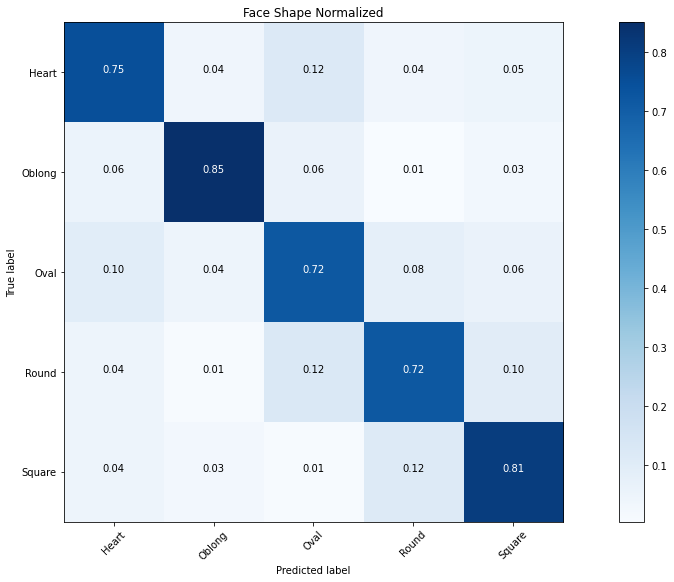

In [ ]:
make_predictions(model_5)